# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [ ]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

#### Descarga de datos


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1h1V3MeECq80s1KY88ZoX4wkwRz0YS1XD' -O DailyClimate_Train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-D0C3Rh3wZR9GQ3xJionL_fcOF5IbAYZ' -O DailyClimate_test.csv

--2023-11-19 18:57:45--  https://docs.google.com/uc?export=download&id=1h1V3MeECq80s1KY88ZoX4wkwRz0YS1XD
Resolving docs.google.com (docs.google.com)... 172.217.204.113, 172.217.204.138, 172.217.204.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ds9mr88kh8ceegriilkipnns1mfp60il/1700420250000/15870504552633603898/*/1h1V3MeECq80s1KY88ZoX4wkwRz0YS1XD?e=download&uuid=3bf02e5d-e59e-4367-8798-d83c8c9f8b9e [following]
--2023-11-19 18:57:45--  https://doc-0s-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ds9mr88kh8ceegriilkipnns1mfp60il/1700420250000/15870504552633603898/*/1h1V3MeECq80s1KY88ZoX4wkwRz0YS1XD?e=download&uuid=3bf02e5d-e59e-4367-8798-d83c8c9f8b9e
Resolving doc-0s-c8-docs.googleusercontent.com (doc-0s-c8-docs.googleusercontent.com)... 74.125.134.132, 2607:f

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [ ]:
train_df = pd.read_csv("DailyClimate_Train.csv")
test_df = pd.read_csv("DailyClimate_test.csv")

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [ ]:
### Start code here ###
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [ ]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
#Cambiar formato de tiempo
train_df.date = pd.to_datetime(train_df.date)
time = train_df.date.dt.strftime('%d/%m/%y')

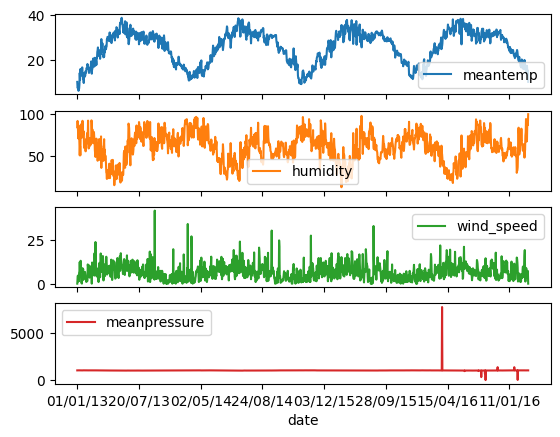

In [ ]:
#Graficos de ejemplo
plot_cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
plot_features = train_df[plot_cols]
plot_features.index = time
_ = plot_features.plot(subplots=True)

In [ ]:
train_df.loc[train_df["meanpressure"] > 7000]

,meantemp,humidity,wind_speed,meanpressure
1182,25.933333,52.8,6.546667,7679.333333


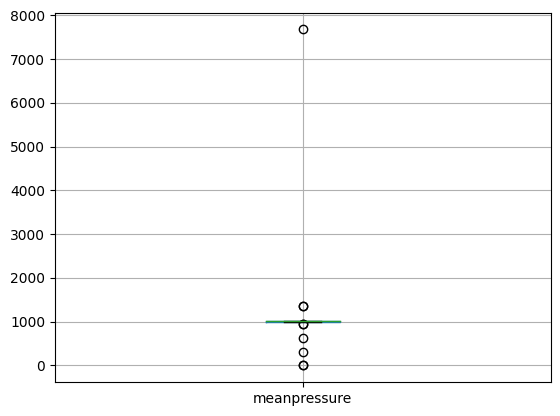

In [ ]:
boxplot = train_df.boxplot(column=['meanpressure'])

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [ ]:
time = pd.to_datetime(time)
timestamp_s = time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
month = day*30
year = (365.2425)*day

train_df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_df['month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
train_df['month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
train_df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

train_df.pop('date')

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1457   2016-12-28
1458   2016-12-29
1459   2016-12-30
1460   2016-12-31
1461   2017-01-01
Name: date, Length: 1462, dtype: datetime64[ns]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std

In [ ]:
train_df

,meantemp,humidity,wind_speed,meanpressure,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
0,-2.108778,1.414955,-1.491189,0.025313,-0.585807,NaN,-0.289284,-1.388201,0.013918,1.412169
1,-2.462611,1.862191,-0.837909,0.037149,-0.041663,NaN,-0.570324,-1.296854,0.730894,1.208863
2,-2.494366,1.564034,-0.475464,0.041958,0.896484,NaN,0.004599,-1.419100,1.208613,0.732839
3,-2.290231,0.629806,-1.220816,0.033635,1.440629,NaN,-0.289284,-1.388201,1.414104,0.016949
4,-2.653137,1.554095,-0.680070,0.029936,0.962231,NaN,-0.289284,-1.388201,1.238789,-0.682730
...,...,...,...,...,...,...,...,...,...,...
1457,-1.126567,0.433627,-0.713430,0.024750,0.757563,NaN,0.835436,1.138832,-0.082620,1.409824
1458,-1.395928,1.615146,-0.175861,0.032182,-1.681526,NaN,1.055037,0.941034,-0.058321,1.411035
1459,-1.551459,1.723051,-0.117402,0.037730,-0.658983,NaN,1.228729,0.701885,-0.034006,1.411829
1460,-1.421168,1.564034,0.114607,0.027717,0.363560,NaN,1.348921,0.431837,-0.009681,1.412204


In [ ]:
objective_col = 'meantemp' # columna objetivo
selected_cols = #TODO # lista de columnas seleccionadas para entrenar

In [ ]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
selected_cols = train_df.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() #solo ejecutar a modo de ejemplo

In [ ]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'meantemp']

In [ ]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [ ]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [ ]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [ ]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = #TODO
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = #TODO
        self.output_linear = #TODO

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = #TODO # Aplicar dropout
        x = #TODO # Aplicar linear1
        x = #TODO # Aplicar linear2
        x = #TODO # Aplicar output_linear
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# Hiperparametros del modelo
input_size = shape-1
hidden_size = #TODO
num_layers = #TODO
dropout = #TODO
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = #TODO
optimizer = #TODO

# loss func: MSE
loss_fn = #TODO

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [ ]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [ ]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            #TODO # Forward pass
            #TODO # Compute loss
            #TODO # Zero gradients
            #TODO # Backward pass
            #TODO # Update weights

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [ ]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [ ]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [ ]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [ ]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

In [ ]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluacion

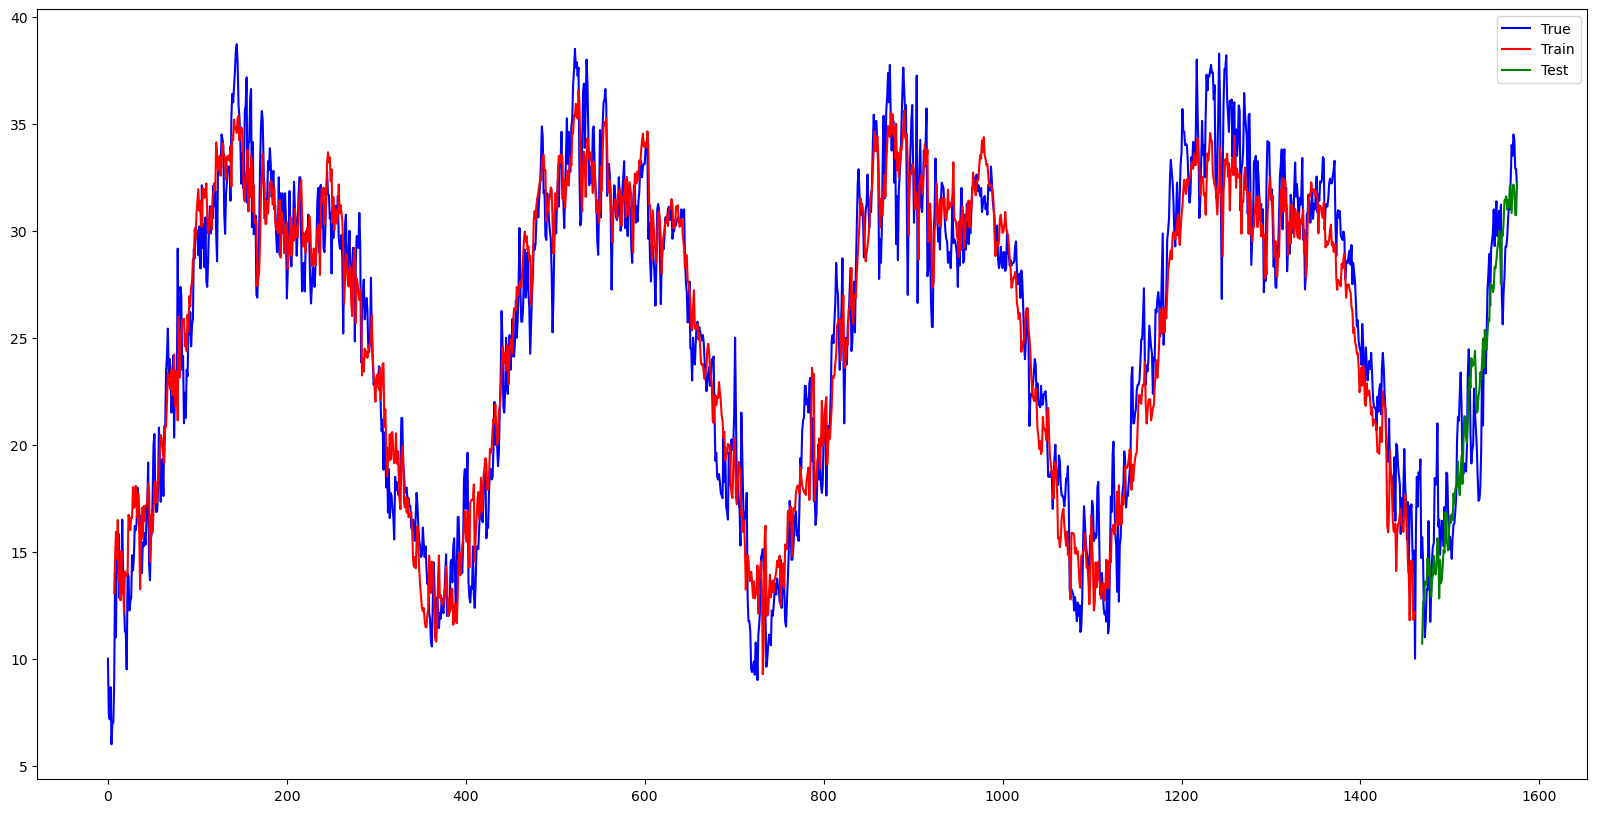

In [ ]:
plot_predictions(train_predictions, test_predictions)

In [ ]:
plot_eval(test_predictions)

RMSE: 2.504925946161387


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bao2VlSnoShKulPhO28NSh3fu-CPBhws' -O el_quijote.txt

--2023-11-23 00:00:09--  https://docs.google.com/uc?export=download&id=1Bao2VlSnoShKulPhO28NSh3fu-CPBhws
Resolving docs.google.com (docs.google.com)... 74.125.134.138, 74.125.134.100, 74.125.134.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.134.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fcicqkq3jfjo0bduo1qacqijg3tfjo8s/1700697600000/15870504552633603898/*/1Bao2VlSnoShKulPhO28NSh3fu-CPBhws?e=download&uuid=1982c966-9b15-46c9-a65c-4ac9d164d3b7 [following]
--2023-11-23 00:00:10--  https://doc-04-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fcicqkq3jfjo0bduo1qacqijg3tfjo8s/1700697600000/15870504552633603898/*/1Bao2VlSnoShKulPhO28NSh3fu-CPBhws?e=download&uuid=1982c966-9b15-46c9-a65c-4ac9d164d3b7
Resolving doc-04-c8-docs.googleusercontent.com (doc-04-c8-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:

In [ ]:
with open('el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [ ]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [ ]:
chars = list(set(text.strip()))
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: 9¡QaABqmo<g1ir.7'Tu08VN«x"Ey5]̀lF6dn3X”!SW4’RPOZ)sC‘pLf:vM-D[jJcbGhI;–̃K2
z ,Ye»Ut?̈“(H́¿
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [ ]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[2, 18, 12, 61, 8, 81, 78, 75, 34, 78, 75, 31, 3, 75, 57, 3, 35, 63, 66, 3]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

* Tokenización por Palabras: Divide el texto en palabras individuales, lo que puede facilitar el análisis semántico. Es útil para muchas tareas de NLP, como el análisis de sentimientos, la clasificación de documentos y la generación de texto.
* Tokenización por Frases: Divide el texto en oraciones individuales. Es útil para tareas que requieren el procesamiento de oraciones completas, como la traducción automática y el resumen de texto.
* Tokenización por Subpalabras: Divide el texto en unidades más pequeñas que las palabras, como subpalabras. Este enfoque es útil para tratar con palabras desconocidas, lidiar con errores tipográficos o reducir el vocabulario, lo que puede ser beneficioso en modelos de lenguaje y tareas de NLP.
* Tokenización por N-gramas: Divide el texto en secuencias contiguas de N elementos, como bigramas (2-gramas) o trigramas (3-gramas). Este enfoque puede capturar mejor las relaciones contextuales en el texto.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

Se pueden emplear técnicas de limpieza de texto para mejorar la calidad y la uniformidad de los datos. Esto incluye la eliminación de caracteres especiales, puntuación innecesaria y cualquier otro símbolo no relevante para reducir el ruido. Asimismo, convertir todo el texto a minúsculas asegura consistencia en el análisis. Además, se puede llevar a cabo la eliminación de stopwords, que consiste en desechar palabras comunes que aportan poco significado al texto, como "y", "el", "un", etc. Otras técnicas útiles son la normalización del texto, el manejo de números y fechas, y la eliminación de URLs.

### 3.4 Train y Val Split

In [ ]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = int(len(text) * 0.8) #% de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:100]) # los primeros 100 caracteres del texto codificado

torch.Size([830717]) torch.int64
tensor([59, 46, 22, 75,  2, 80, 67, 62, 46, 17, 26, 75, 59, 26, 75, 53,  4, 75,
        57,  4, 22, 50, 86,  4, 73, 57, 12, 10, 18, 78, 31, 75, 34, 78, 75, 50,
        78, 13, 56,  3, 35, 81, 78, 49, 75, 40,  3,  3, 56, 78, 34, 13,  3, 73,
        73, 45, 44, 67, 57, 26, 44,  4, 75, 45,  4, 44, 17, 26, 73, 50,  4, 45,
        67, 87, 17, 80, 53, 46, 75, 11, 55, 75,  2, 18, 78, 75, 81, 13,  3, 81,
         3, 75, 34, 78, 75, 31,  3, 75, 63,  8])


### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [ ]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 3, 13,  6, 18, 78, 87, 49, 75],
        [75, 56, 78, 49, 81, 12, 34,  8],
        [ 3, 75,  7, 18, 61, 78, 13, 12],
        [63, 12, 78, 13, 81,  8, 75,  6]])
targets:
torch.Size([4, 8])
tensor([[13,  6, 18, 78, 87, 49, 75, 34],
        [56, 78, 49, 81, 12, 34,  8, 49],
        [75,  7, 18, 61, 78, 13, 12, 78],
        [12, 78, 13, 81,  8, 75,  6, 18]])
----
cuando el input es tensor([3]) el target es: 13
cuando el input es tensor([ 3, 13]) el target es: 6
cuando el input es tensor([ 3, 13,  6]) el target es: 18
cuando el input es tensor([ 3, 13,  6, 18]) el target es: 78
cuando el input es tensor([ 3, 13,  6, 18, 78]) el target es: 87
cuando el input es tensor([ 3, 13,  6, 18, 78, 87]) el target es: 49
cuando el input es tensor([ 3, 13,  6, 18, 78, 87, 49]) el target es: 75
cuando el input es tensor([ 3, 13,  6, 18, 78, 87, 49, 75]) el target es: 34
cuando el input es tensor([75]) el target es: 56
cuando el input es tensor([75, 56]) el target es: 7

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Obtener los logits y la pérdida
            logits, loss = self(idx)
            # Selecciona los logits correspondientes al último token
            logits = logits[:, -1, :]
            # Calcula las probabilidades normalizadas a partir de los logits
            probs = F.softmax(logits, dim=-1)
            # seleccionar el próximo token de acuerdo con la distribución de probabilidad
            idx_next = torch.multinomial(probs, num_samples=1)
            # Concatena el token al final de la secuencia actual
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

Genera una cantidad max_new_tokens de caracteres a partir de un prompt inicial idx.

In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(naive_model.parameters())
batch_size = 52
epochs = 200

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    x, y = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    preds, loss = naive_model.forward(x,y)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 4.9093
Epoch 10 | Loss 5.0065
Epoch 20 | Loss 4.9271
Epoch 30 | Loss 4.9953
Epoch 40 | Loss 4.8515
Epoch 50 | Loss 4.9216
Epoch 60 | Loss 4.9054
Epoch 70 | Loss 4.9186
Epoch 80 | Loss 4.9948
Epoch 90 | Loss 4.8452
Epoch 100 | Loss 4.8297
Epoch 110 | Loss 4.8190
Epoch 120 | Loss 4.9635
Epoch 130 | Loss 4.8094
Epoch 140 | Loss 4.7623
Epoch 150 | Loss 4.7858
Epoch 160 | Loss 4.6812
Epoch 170 | Loss 4.7212
Epoch 180 | Loss 4.7236
Epoch 190 | Loss 4.7663


In [ ]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.679775714874268
Vhymc[́I¿'yzDRq́p.̀[Telpr̀Rgl
’y¿TL¡J«[!u ?E’¡ZKD9l;3.–sI1ODh¿(T':Pć«tLmM̈’A-eb)s‘,G08[<xo(Lä̃8A«t'


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
n_embd = 512 # dimension de los embeddings
n_head = 8 # numero de cabezas de atencion
n_layer = 6 # numero de capas
dropout = 0.1 # dropout

In [ ]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = nn.Softmax(dim=-1)
        dropout = self.dropout(softmax(wei))
        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)
        out = dropout @ v
        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

Permite a una red neuronal concentrarse más o menos en distintos segmentos de la secuencia de input, regulando la importancia que le da a cada uno.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd,n_embd),
            nn.ReLU(),
            nn.Linear(n_embd,n_embd)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**

Se implementa la atención multi cabeza y la parte feedforward en un bloque transformer. Este bloque luego puede ser reutilizado muchas veces para construir modelos de mayor complejidad.

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)

        x = tok_emb + pos_emb # (B,T,C)

        x = self.blocks(x) # (B,T,C)

        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

No :( Pytorch esta bizarro

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 0.001
optimizer = torch.optim.Adam(m.parameters(), lr=lr)
epochs = 1000
eval_interval = 100
eval_iters = 200

9.564249 M parameters


In [ ]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # obtenemos un batch de datos
    x, y = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    preds, loss = model.forward(x,y)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

step 0: train loss 4.6147, val loss 4.6272
step 100: train loss 2.5387, val loss 2.5568
step 200: train loss 2.4358, val loss 2.4339
step 300: train loss 2.4377, val loss 2.4370
step 400: train loss 2.3312, val loss 2.4218
step 500: train loss 2.3120, val loss 2.3170
step 600: train loss 2.3502, val loss 2.3723
step 700: train loss 2.2816, val loss 2.3605
step 800: train loss 2.3367, val loss 2.3687
step 900: train loss 2.2734, val loss 2.2886
step 999: train loss 2.2584, val loss 2.2767


In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

9os mo colal magall mán eltenen, se centan podarer aná la el uvilo na copuudhal geln re tegpesstodo on pol e-calte ey Ben nome coquedinalabre laghamon pommodados vá lala he rálí lestaEas ejaque cortelvóls al tenis te tedquen. hotrasisdo sú stadmol que R ari, pomilmu en tátragas ole sicucunto vintra a. ponto– y a Y la porvo ol stimal, von emte pel poagonque mez ar conta toude,, delaque Rocos helas en lo que, poque l berarl qué a labbrambrY o zorcie metomllste cod peiototós se do ven ar, ca fechos niciỹmos a s hunintos terden vese cicopenen que demrgid quegue funa el, e tentos velcodell ada tri asuponda Ben omó mrtosun mocuesmbod égon veno digubintdar avelán miar que alo ecita, enzontos polgol dé Co dbálgie: do! en Zod lan alaguntor RRon a, vonmera. anto hoque pos anoreala rerll comirdes sto, pen cue s mól en le síicbro? pos coml os .y ocon Ros erl que hue por er cocen quen entecid iCeño qubbos; poundila gotióa, altitrantont, Rellaltubalged enter co, pon colgun pir se

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.